In [1]:
# uncomment if you haven't installed the package
# !pip install -e "git+https://github.com/daffarobani/smt-explainability.git"#egg=smt-ex
# !pip install sobolsampling

In [6]:
from smt.surrogate_models import KRG
from smt_ex.problems import MixedCantileverBeam
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from smt.applications.mixed_integer import MixedIntegerKrigingModel

from smt_ex.shap.shap_display import ShapDisplay
from smt_ex.shap.shap_feature_importance_display import ShapFeatureImportanceDisplay

from sklearn.metrics import mean_squared_error
import numpy as np
import time

In [3]:
ndoe = 250
n_train = int(0.8 * ndoe)
fun = MixedCantileverBeam()
# Name of the features
feature_names = [r'$\tilde{I}$', r'$L$', r'$S$']
# Index for categorical features
categorical_feature_indices = [0]
# Design space
ds = DesignSpace([
    CategoricalVariable(values=[str(i + 1) for i in range(12)]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_indices:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for i, value in enumerate(ds._design_variables[feature_idx].values)
    }

X = fun.sample(ndoe)
y = fun(X)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

class GroundTruthModel:
    def predict_values(self, X):
        return fun(X)
    
gtm = GroundTruthModel()

In [4]:
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )


start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

/Users/muhammaddaffarobani/miniconda3/envs/smt_ex_39/lib/python3.9/site-packages/smt/applications/mixed_integer.py:205: UserWarning: TNC not available yet for mixed integer handling. Switching to Cobyla
  warnings.warn(


run time (s): 32.087157011032104
Surrogate model
RMSE: 0.0001
rRMSE: 0.0534


/Users/muhammaddaffarobani/miniconda3/envs/smt_ex_39/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
instances = X_tr
model = sm

kernel_shap_explainer = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X_tr, 
    feature_names=feature_names,
    categorical_feature_indices=categorical_feature_indices,
    categories_map=categories_map,
    method="kernel",
)

In [8]:
instances = X_tr
model = sm

exact_shap_explainer = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X_tr, 
    feature_names=feature_names,
    categorical_feature_indices=categorical_feature_indices,
    categories_map=categories_map,
    method="exact",
)

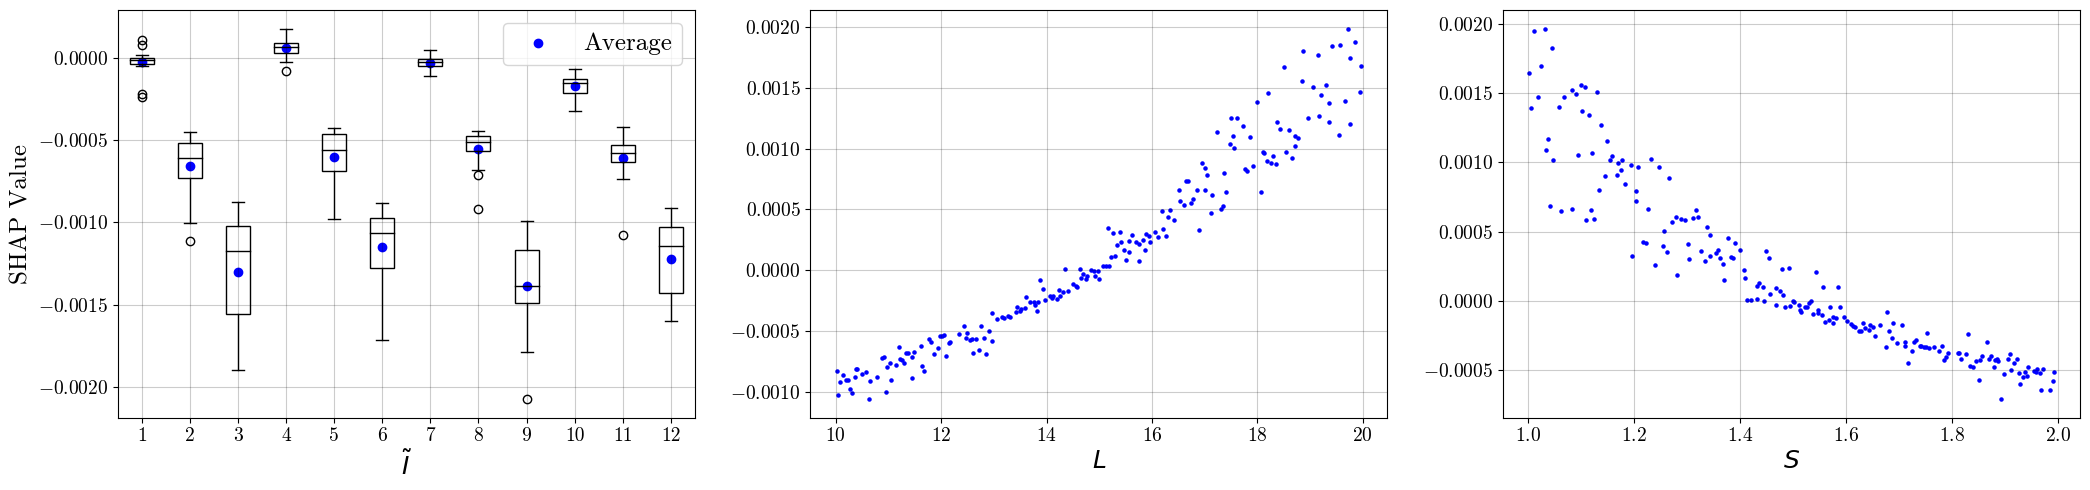

In [9]:
shap_dependence = kernel_shap_explainer.dependence_plot([0, 1, 2], sort_based_on_importance=False)
shap_dependence

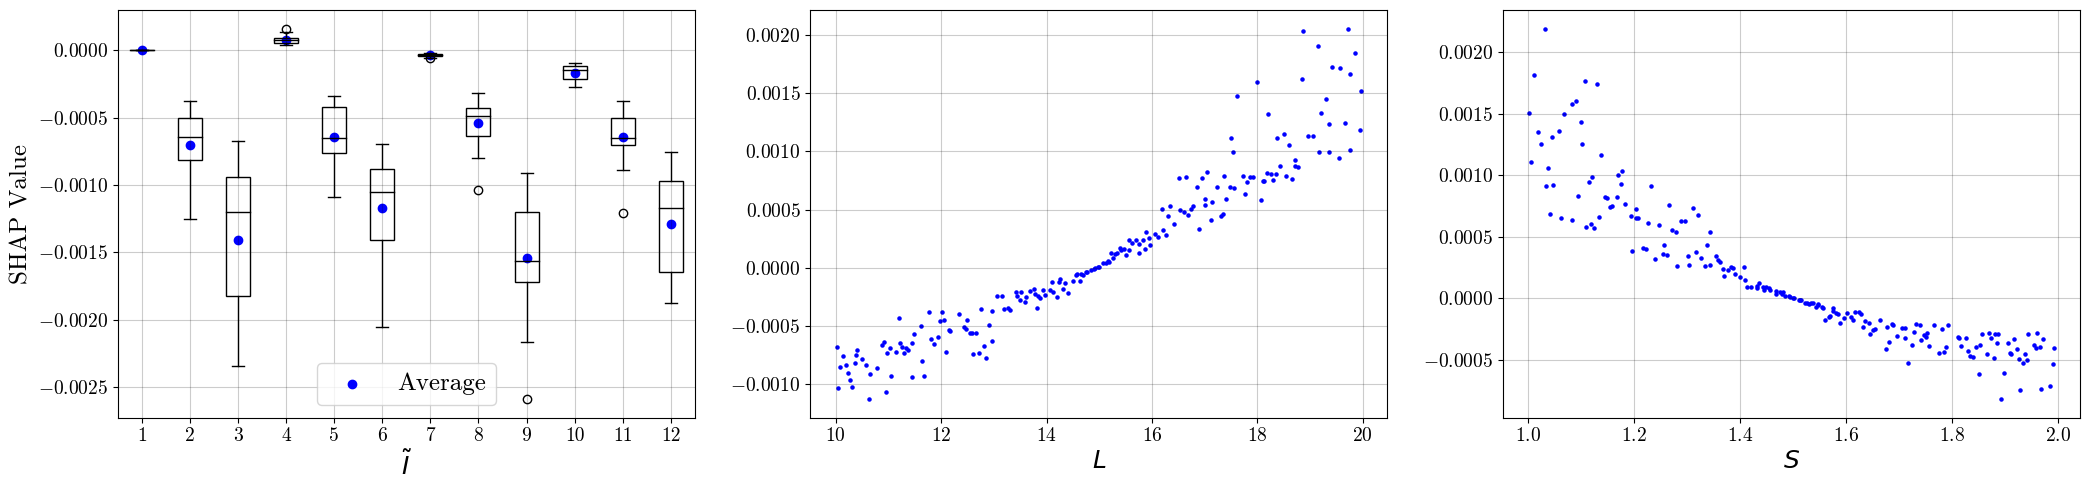

In [10]:
shap_dependence = exact_shap_explainer.dependence_plot([0, 1, 2], sort_based_on_importance=False)
shap_dependence

In [11]:
kernel_shap_feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    sm, 
    X_tr, 
    feature_names=feature_names,
    method="kernel",
    categorical_feature_indices=categorical_feature_indices,
)

exact_shap_feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    sm, 
    X_tr, 
    feature_names=feature_names,
    method="exact",
    categorical_feature_indices=categorical_feature_indices,
)

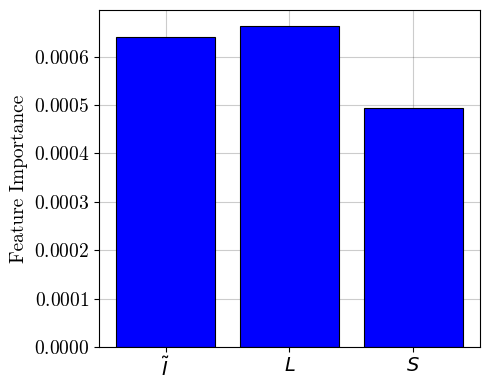

In [12]:
kernel_shap_feature_importance.plot()

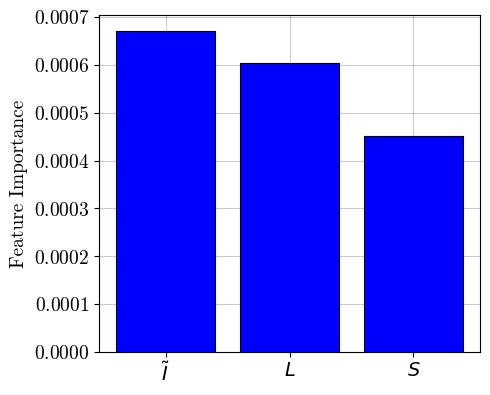

In [13]:
exact_shap_feature_importance.plot()

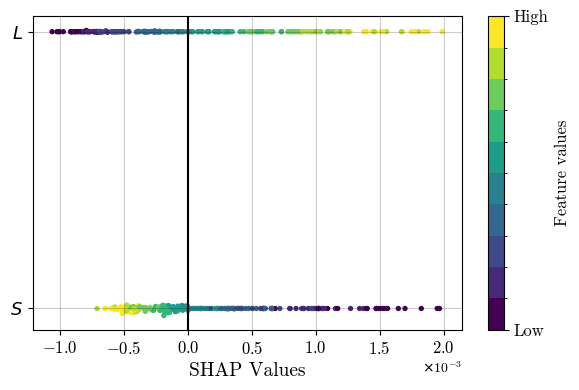

In [14]:
kernel_shap_explainer.summary_plot()

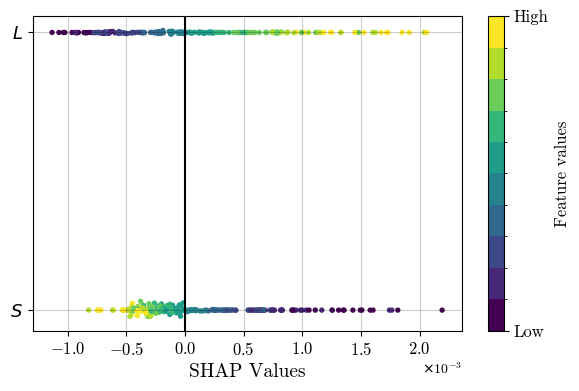

In [15]:
exact_shap_explainer.summary_plot()

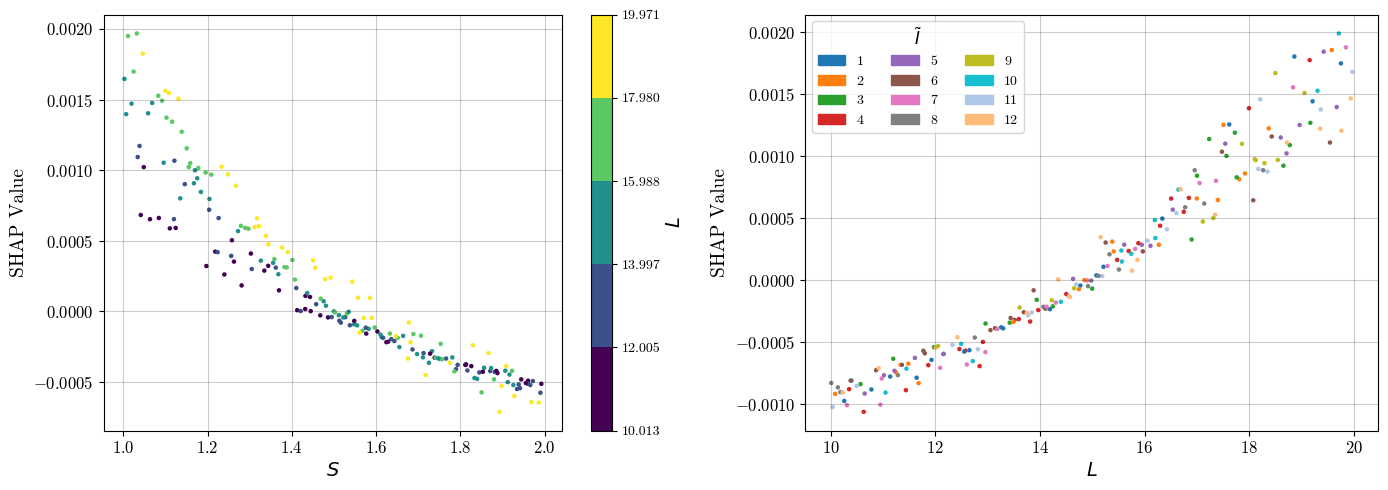

In [16]:
feature_pairs = [(2, 1), (1, 0)]
kernel_shap_explainer.interaction_plot(
    feature_pairs, 
    n_color=5,
    sort_based_on_importance={0: False},
)

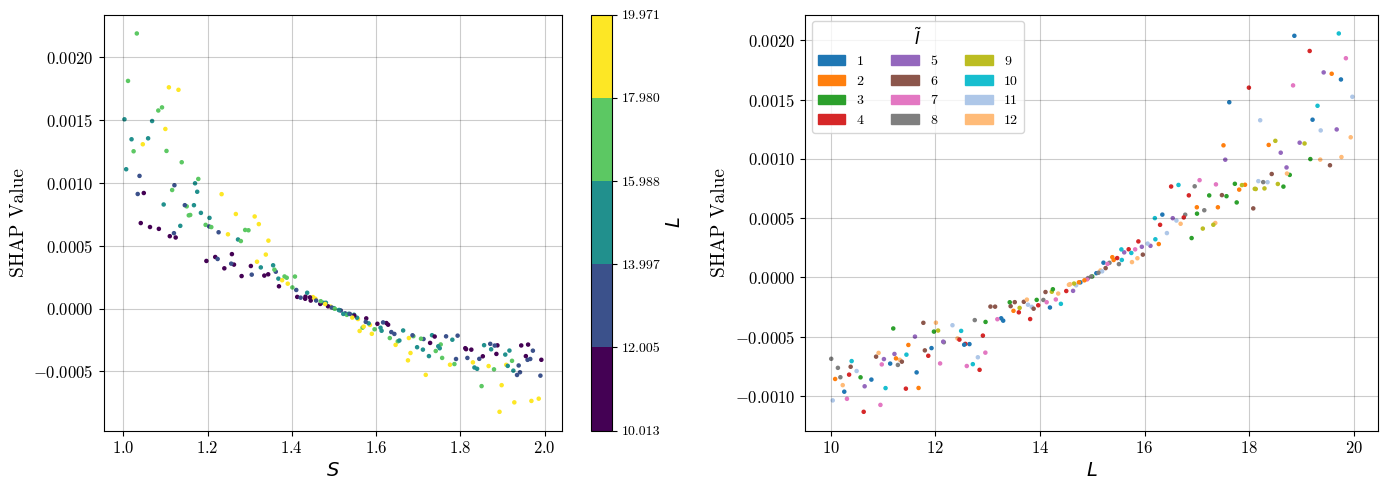

In [17]:
feature_pairs = [(2, 1), (1, 0)]
exact_shap_explainer.interaction_plot(
    feature_pairs, 
    n_color=5,
    sort_based_on_importance={0: False},
)

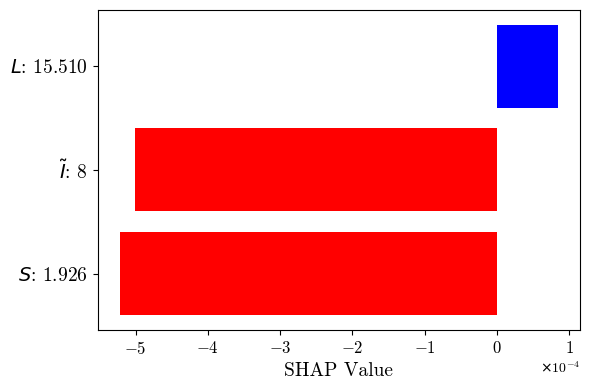

In [18]:
fig = kernel_shap_explainer.individual_plot(index=10)
fig

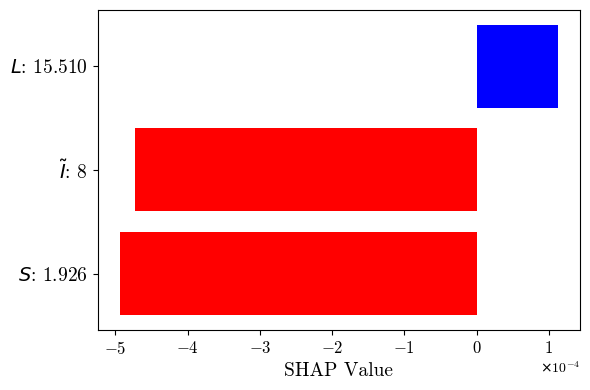

In [19]:
fig = exact_shap_explainer.individual_plot(index=10)
fig